In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')
  nltk.download('wordnet')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

from nltk.translate.meteor_score import single_meteor_score
from nltk import word_tokenize

from bert_score import BERTScorer, score
from nubia_score import Nubia

import toml
from tqdm import tqdm

from IPython.display import display


In [3]:
with open('config.toml', 'r') as f:
    config = toml.load(f)
    print(config)

{'useEmbeddings': False, 'openAiApiKey': '5f922fc571534517acc85c31d6af4bbf', 'dataPath': 'data/summary/logs/Zookeeper.txt', 'logsSourceApplication': 'Zookeeper', 'engines': ['gpt3', 'gpt4'], 'outputDir': 'out', 'outputFilename': 'zookeeper_without_embeddings', 'data': {'splitRandomState': 0, 'trainProportion': 0.75}, 'model': {'temperature': 0.3, 'maxTokens': 250, 'topP': 1, 'frequencyPenalty': 0, 'presencePenalty': 0}, 'embedding': {'useEmbeddings': False, 'model': 'text-embedding-ada-002', 'deployment': 'cs598', 'resourceEndpoint': 'https://openaics598.openai.azure.com', 'apiKey': '5309dd9cfd0e4e9cadd598ee91321fcf', 'openAiApiVersion': '2023-05-15', 'chunkSize': 16, 'openAiApiType': 'azure', 'redis': {'hostName': 'localhost', 'port': '6379', 'indexName': 'log_data', 'kDocs': 5}}}


## Lexical metrics:
* BLEU Score
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * 0.4-0.6 is considered reasonable and indicates some level of similarity
  * above 0.6 is considered quite good
  
* ROUGE Score
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * round 0.2-0.4 indicates some level of overlap
  * above 0.4 is considered good

* Meteor Score
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * 0.4-0.6 is considered reasonable and indicates some level of similarity
  * above 0.6 is considered quite good

In [4]:
def bleu_score(ref, gen):
  smoother = SmoothingFunction()
  return sentence_bleu([ref.split()], gen.split(), smoothing_function=smoother.method4)


def rouge_score(ref, gen):
  return rouge_scorer \
    .RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True) \
    .score(ref, gen)["rougeL"] \
    .fmeasure


def meteor_score(ref, gen):
  return single_meteor_score(word_tokenize(ref), word_tokenize(gen))

def bert_score(ref, gen):
  p, r, f1 = BERTScorer(model_type='bert-base-uncased').score([gen], [ref])
  return f1.item()

def bleurt_score(ref, gen):
  p, r, f1 = score([gen], [ref], lang="en", verbose=False)
  return f1.item()

def nubia_score(ref, gen):
  return Nubia().score(ref, gen, verbose=False, get_features=True)['nubia_score']

def plot_results(scores, title):
  df_long = scores.melt(var_name='Metrics', value_name='Value')
  plt.figure(figsize=(5, 3))
  sns.boxplot(x='Metrics', y='Value', data=df_long, width=0.5, showfliers=False)
  sns.stripplot(x='Metrics', y='Value', data=df_long, jitter=True, color='black', alpha=0.5)

  plt.axhline(0.2, color='red', linestyle='--', label=f'Threshold 1: {0.2}')
  plt.axhline(0.4, color='green', linestyle='--', label=f'Threshold 2: {0.4}')

  plt.title(title)
  plt.show()

## Semantic metrics:
* BERTScore
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * 0.6-0.7 is considered good and indicates that the generated text is similar to the reference in terms of both vocabulary and context.
  * above 0.6 is considered quite good
  
* BLEURT
  * typically range from negative to positive
  * A positive BLEURT score indicates that the generated text is considered better than randomly generated text. The higher the positive score, the better the quality.
  * A negative BLEURT score suggests that the generated text is worse than randomly generated text. The lower the negative score, the worse the quality.
  * A BLEURT score near zero implies that the quality of the generated text is neither better nor worse than randomly generated text.

* NUBIA
  * Range from 0 to 1, Higher Is Better
  * how good of a substitute/replacement the candidate sentence is for the reference sentence.



In [85]:
def process_dataset(file):
  df = pd.read_csv(file)

  refs = [ref.replace("['", "").replace("']", "") for ref in df["ref"]]
  df["ref"] = refs
  
  bleu_scores = []
  rouge_scores = []
  meteor_scores = []
  bert_scores = []
  bleurt_scores = []
  nubia_scores = []
  for summary, ref_log in tqdm(list(zip(refs, df["log"]))):
    bleu_scores.append(bleu_score(ref_log, summary))
    rouge_scores.append(rouge_score(ref_log, summary))
    meteor_scores.append(meteor_score(ref_log, summary))
    bert_scores.append(bert_score(ref_log, summary))
    bleurt_scores.append(bleurt_score(ref_log, summary))
    nubia_scores.append(nubia_score(ref_log, summary))
    
  df[f"ref BLEU"] = bleu_scores
  df[f"ref ROUGE"] = rouge_scores
  df[f"ref METEOR"] = meteor_scores
  df[f"ref BERT"] = bert_scores
  df[f"ref BLEURT"] = bleurt_scores
  df[f"ref NUBIA"] = nubia_scores
  
  for engine in config["engines"]:
    summaries = df[f"{engine} summary"]
    ref_summaries = df["ref"]
    ref_logs = df["log"]
    
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    bert_scores = []
    bleurt_scores = []
    nubia_scores = []
    for summary, ref_summary, ref_log in tqdm(list(zip(summaries, ref_summaries, ref_logs))):
      bleu_scores.append(bleu_score(ref_log, summary))
      rouge_scores.append(rouge_score(ref_log, summary))
      meteor_scores.append(meteor_score(ref_log, summary))
      bert_scores.append(bert_score(ref_log, summary))
      bleurt_scores.append(bleurt_score(ref_log, summary))
      nubia_scores.append(nubia_score(ref_log, summary))
        
    df[f"{engine} BLEU"] = bleu_scores
    df[f"{engine} ROUGE"] = rouge_scores
    df[f"{engine} METEOR"] = meteor_scores
    df[f"{engine} BERT"] = bert_scores
    df[f"{engine} BLEURT"] = bleurt_scores
    df[f"{engine} NUBIA"] = nubia_scores
  return df

In [86]:
data_file = f"{config['outputDir']}/zookeeper_with_embeddings.csv"
df_with_embeddings = process_dataset(data_file)
df_with_embeddings.to_csv(data_file.replace(".csv", "_with_metrics.csv"))

  0%|          | 0/25 [00:00<?, ?it/s]2023-12-10 00:40:34 | INFO | absl | Using default tokenizer.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-12-10 00:40:45 | INFO | fairseq.file_utils | loading archive file C:\Users\camer\PycharmProjects\CloudComputingCapstone\venv\lib\site-packages\nubia_score\pretrained/roBERTa_STS


2023-12-10 00:40:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:41:02 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:41:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:42:08 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:43:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:43:09 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:44:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:44:15 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:45:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:45:11 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:45:49 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:45:56 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:46:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:46:40 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:47:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:47:30 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:48:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:48:22 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:49:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:49:10 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:49:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:49:58 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:50:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:50:41 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:51:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:51:28 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:52:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:52:15 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:52:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:53:03 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:53:41 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:53:48 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:54:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:54:32 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:55:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:55:20 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:55:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:56:03 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:56:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:56:48 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:57:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:57:36 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:58:17 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:58:24 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:59:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:59:12 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 00:59:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 00:59:59 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:00:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:00:46 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:01:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:01:31 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:02:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:02:15 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:02:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:03:02 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:03:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:03:50 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:04:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:04:38 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:05:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:05:22 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:05:59 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:06:06 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:06:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:06:54 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:07:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:07:44 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:08:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:08:28 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:09:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:09:11 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:09:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:09:54 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:10:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:10:38 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:11:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:11:25 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:12:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:12:10 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:12:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:12:54 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:13:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:13:35 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:14:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:14:18 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:14:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:14:58 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:15:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:15:39 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:16:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:16:23 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:17:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:17:08 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:17:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:17:52 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:18:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:18:36 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:19:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:19:20 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:19:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:20:02 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:20:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:20:43 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:21:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:21:26 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:22:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:22:11 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:22:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:22:56 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:23:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:23:39 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:24:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:24:22 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:25:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:25:09 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:25:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:25:55 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:26:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:26:37 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:27:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:27:18 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:27:53 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:28:00 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:28:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:28:41 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:29:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:29:25 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:30:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:30:09 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:30:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:30:54 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:31:30 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:31:37 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:32:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:32:17 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:32:51 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:32:58 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:33:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:33:39 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:34:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:34:23 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:35:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:35:07 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:35:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:35:52 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:36:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:36:35 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:37:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:37:20 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

In [87]:
data_file = f"{config['outputDir']}/zookeeper_without_embeddings.csv"
df_without_embeddings = process_dataset(data_file)
df_without_embeddings.to_csv(data_file.replace(".csv", "_with_metrics.csv"))

  0%|          | 0/25 [00:00<?, ?it/s]2023-12-10 01:37:44 | INFO | absl | Using default tokenizer.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-12-10 01:37:52 | INFO | fairseq.file_utils | loading archive file C:\Users\camer\PycharmProjects\CloudComputingCapstone\venv\lib\site-packages\nubia_score\pretrained/roBERTa_STS


2023-12-10 01:37:55 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:38:02 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:38:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:38:44 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:39:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:39:25 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:40:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:40:09 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:40:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:40:57 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:41:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:41:39 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:42:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:42:23 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:43:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:43:08 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:43:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:43:55 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:44:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:44:38 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:45:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:45:19 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:45:53 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:46:00 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:46:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:46:41 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:47:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:47:25 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:48:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:48:09 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:48:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:48:52 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:49:26 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:49:33 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:50:07 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:50:14 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:50:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:50:54 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:51:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:51:35 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:52:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:52:19 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:52:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:53:05 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:53:42 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:53:49 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:54:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:54:32 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:55:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:55:16 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:55:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:55:58 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:56:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:56:39 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:57:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:57:20 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:57:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:58:04 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:58:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:58:50 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 01:59:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 01:59:34 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:00:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:00:17 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:00:55 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:01:02 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:01:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:01:49 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:02:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:02:32 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:03:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:03:12 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:03:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:03:53 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:04:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:04:34 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:05:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:05:19 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:05:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:06:03 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:06:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:06:46 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:07:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:07:27 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:08:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:08:08 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:08:42 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:08:48 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:09:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:09:30 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:10:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:10:13 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:10:51 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:10:58 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:11:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:11:43 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:12:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:12:26 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:13:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:13:13 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:13:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:13:55 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:14:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:14:35 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:15:09 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:15:16 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:15:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:16:00 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:16:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:16:45 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:17:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:17:28 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:18:07 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:18:13 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:18:53 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:18:59 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:19:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:19:45 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:20:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:20:27 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:21:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:21:08 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:21:42 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:21:49 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:22:24 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:22:31 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:23:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:23:14 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:23:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:23:58 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:24:35 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:24:41 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:25:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:25:22 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:25:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:26:04 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:26:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:26:44 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:27:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:27:25 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:28:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:28:10 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:28:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:28:54 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:29:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:29:39 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:30:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:30:22 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

2023-12-10 02:31:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 50265 types
2023-12-10 02:31:07 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'tqdm', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': '', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': 1.0, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppr

In [88]:
ref_bleu_scores = df_with_embeddings["ref BLEU"].tolist()
ref_rouge_scores = df_with_embeddings["ref ROUGE"].tolist()
ref_meteor_scores = df_with_embeddings["ref METEOR"].tolist()
ref_bert_scores = df_with_embeddings["ref BERT"].tolist()
ref_bleurt_scores = df_with_embeddings["ref BLEURT"].tolist()
ref_nubia_scores = df_with_embeddings["ref NUBIA"].tolist()
ref_labels = ["Reference Summaries" for _ in range(len(df_with_embeddings))]

gpt3_bleu_scores_embed = df_with_embeddings["gpt3 BLEU"].tolist()
gpt3_rouge_scores_embed = df_with_embeddings["gpt3 ROUGE"].tolist()
gpt3_meteor_scores_embed = df_with_embeddings["gpt3 METEOR"].tolist()
gpt3_bert_scores_embed = df_with_embeddings["gpt3 BERT"].tolist()
gpt3_bleurt_scores_embed = df_with_embeddings["gpt3 BLEURT"].tolist()
gpt3_nubia_scores_embed = df_with_embeddings["gpt3 NUBIA"].tolist()
gpt3_labels_embed = ["ChatGPT 3.5 w/out embeddings" for _ in range(len(df_with_embeddings))]

gpt4_bleu_scores_embed = df_with_embeddings["gpt4 BLEU"].tolist()
gpt4_rouge_scores_embed = df_with_embeddings["gpt4 ROUGE"].tolist()
gpt4_meteor_scores_embed = df_with_embeddings["gpt4 METEOR"].tolist()
gpt4_bert_scores_embed = df_with_embeddings["gpt4 BERT"].tolist()
gpt4_bleurt_scores_embed = df_with_embeddings["gpt4 BLEURT"].tolist()
gpt4_nubia_scores_embed = df_with_embeddings["gpt4 NUBIA"].tolist()
gpt4_labels_embed = ["ChatGPT 4 w/out embeddings" for _ in range(len(df_with_embeddings))]

gpt3_bleu_scores_no_embed = df_without_embeddings["gpt3 BLEU"].tolist()
gpt3_rouge_scores_no_embed = df_without_embeddings["gpt3 ROUGE"].tolist()
gpt3_meteor_scores_no_embed = df_without_embeddings["gpt3 METEOR"].tolist()
gpt3_bert_scores_no_embed = df_without_embeddings["gpt3 BERT"].tolist()
gpt3_bleurt_scores_no_embed = df_without_embeddings["gpt3 BLEURT"].tolist()
gpt3_nubia_scores_no_embed = df_without_embeddings["gpt3 NUBIA"].tolist()
gpt3_labels_no_embed = ["ChatGPT 3.5 w/ embeddings" for _ in range(len(df_without_embeddings))]

gpt4_bleu_scores_no_embed = df_without_embeddings["gpt4 BLEU"].tolist()
gpt4_rouge_scores_no_embed = df_without_embeddings["gpt4 ROUGE"].tolist()
gpt4_meteor_scores_no_embed = df_without_embeddings["gpt4 METEOR"].tolist()
gpt4_bert_scores_no_embed = df_without_embeddings["gpt4 BERT"].tolist()
gpt4_bleurt_scores_no_embed = df_without_embeddings["gpt4 BLEURT"].tolist()
gpt4_nubia_scores_no_embed = df_without_embeddings["gpt4 NUBIA"].tolist()
gpt4_labels_no_embed = ["ChatGPT 4 w/ embeddings" for _ in range(len(df_without_embeddings))]

score_df = pd.DataFrame(
  {
    "Summaries Source": ref_labels + gpt3_labels_no_embed + gpt3_labels_embed + gpt4_labels_no_embed + gpt4_labels_embed,
    "BLEU Score": ref_bleu_scores + gpt3_bleu_scores_no_embed + gpt3_bleu_scores_embed + gpt4_bleu_scores_no_embed + gpt4_bleu_scores_embed,
    "ROUGE Score": ref_rouge_scores + gpt3_rouge_scores_no_embed + gpt3_rouge_scores_embed + gpt4_rouge_scores_no_embed + gpt4_rouge_scores_embed,
    "METEOR Score": ref_meteor_scores + gpt3_meteor_scores_no_embed + gpt3_meteor_scores_embed + gpt4_meteor_scores_no_embed + gpt4_meteor_scores_embed,
    "BERT Score": ref_bert_scores + gpt3_bert_scores_no_embed + gpt3_bert_scores_embed + gpt4_bert_scores_no_embed + gpt4_bert_scores_embed,
    "BLEURT Score": ref_bleurt_scores + gpt3_bleurt_scores_no_embed + gpt3_bleurt_scores_embed + gpt4_bleurt_scores_no_embed + gpt4_bleurt_scores_embed,
    "NUBIA Score": ref_nubia_scores + gpt3_nubia_scores_no_embed + gpt3_nubia_scores_embed + gpt4_nubia_scores_no_embed + gpt4_nubia_scores_embed,
  }
)

score_df.to_csv("out/scores.csv")



In [89]:
sns.set_context("paper", font_scale=1.25)
sns.set_style("whitegrid")

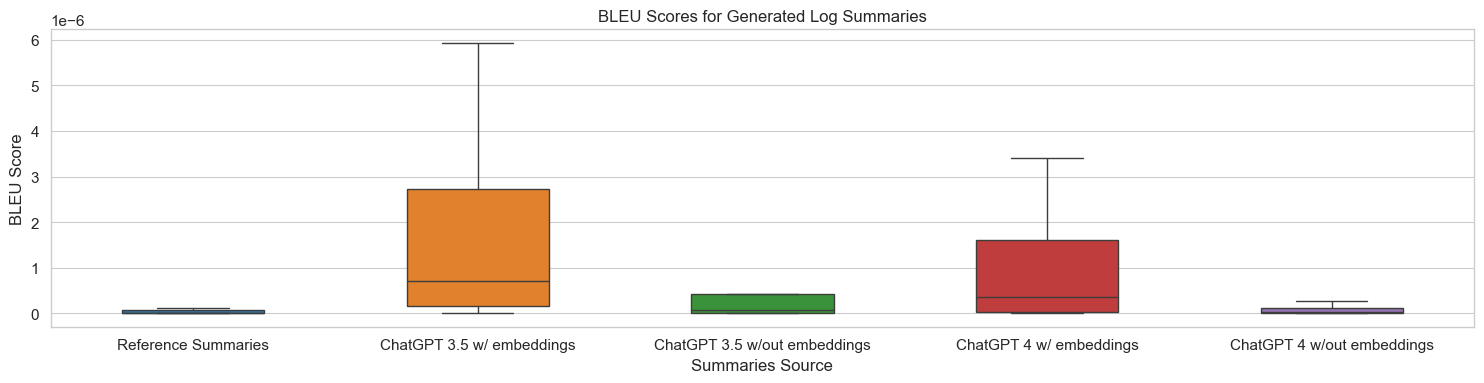

In [90]:
plt.figure(figsize=(15, 4))
sns.boxplot(y='BLEU Score', x='Summaries Source', data=score_df, width=0.5, showfliers=False, hue='Summaries Source')
plt.title("BLEU Scores for Generated Log Summaries")
plt.tight_layout()
plt.savefig("out/img/bleu-scores.png", dpi=600)
plt.show()

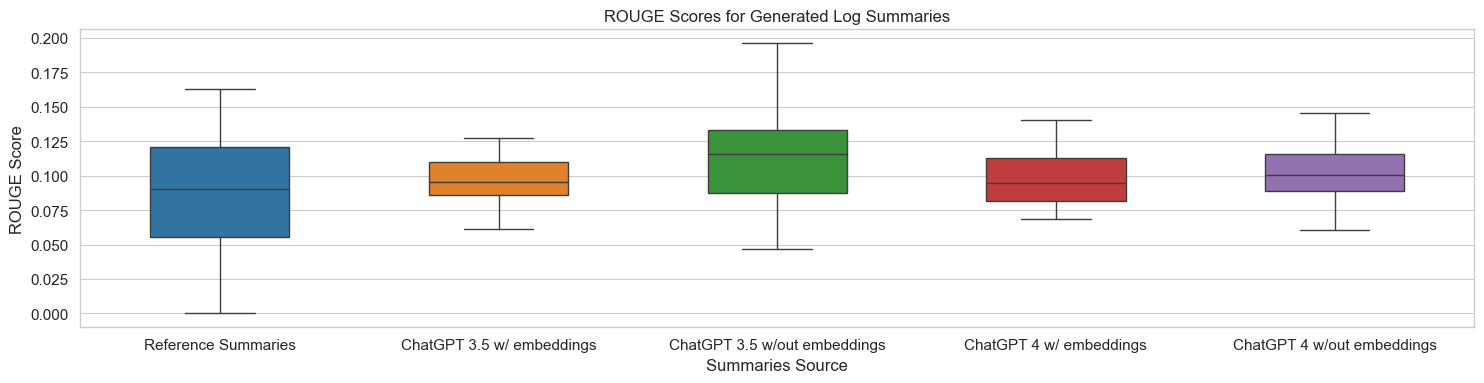

In [91]:
plt.figure(figsize=(15, 4))
sns.boxplot(y='ROUGE Score', x='Summaries Source', data=score_df, width=0.5, showfliers=False, hue='Summaries Source')
plt.title("ROUGE Scores for Generated Log Summaries")
plt.tight_layout()
plt.savefig("out/img/rouge-scores.png", dpi=600)
plt.show()

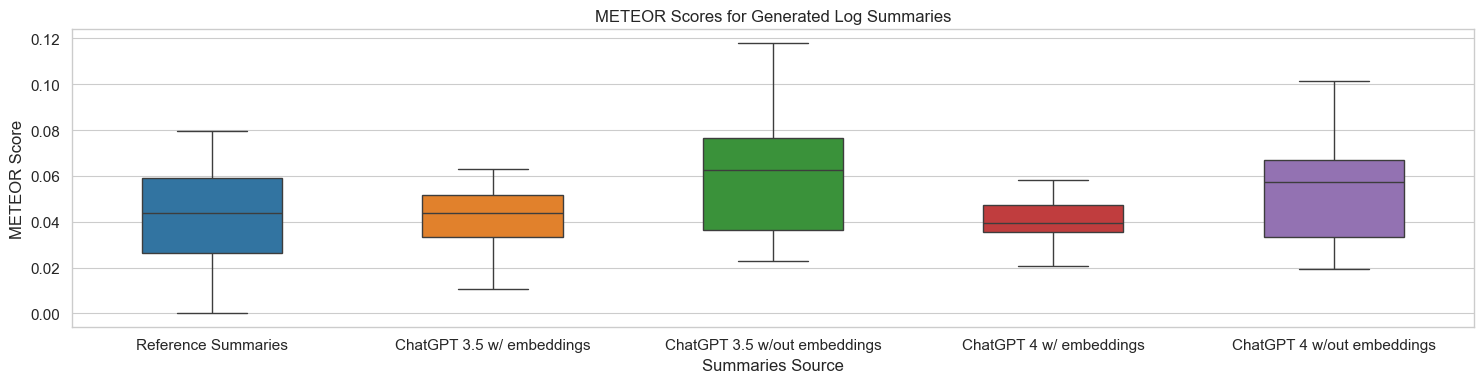

In [92]:
plt.figure(figsize=(15, 4))
sns.boxplot(y='METEOR Score', x='Summaries Source', data=score_df, width=0.5, showfliers=False, hue='Summaries Source')
plt.title("METEOR Scores for Generated Log Summaries")
plt.tight_layout()
plt.savefig("out/img/meteor-scores.png", dpi=600)
plt.show()

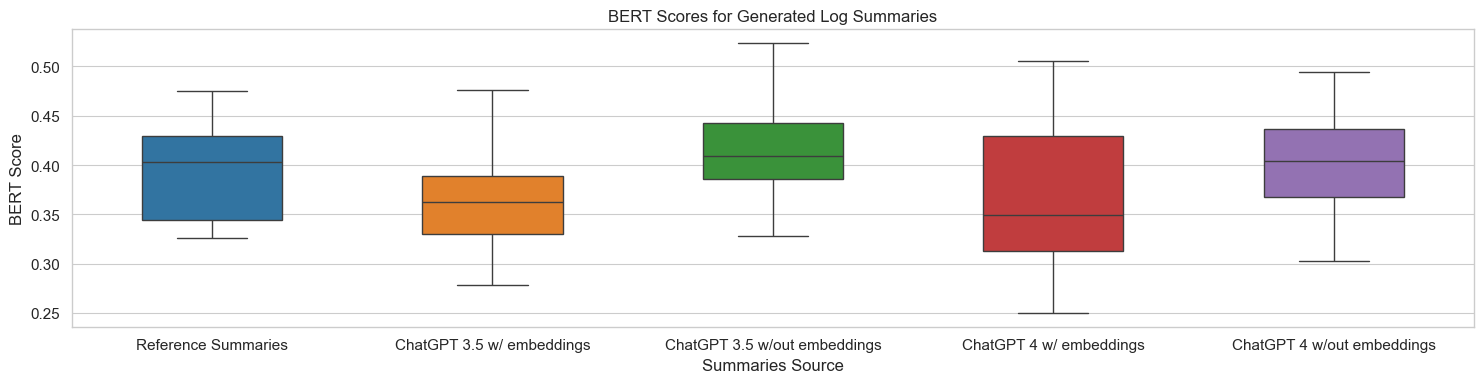

In [93]:
plt.figure(figsize=(15, 4))
sns.boxplot(y='BERT Score', x='Summaries Source', data=score_df, width=0.5, showfliers=False, hue='Summaries Source')
plt.title("BERT Scores for Generated Log Summaries")
plt.tight_layout()
plt.savefig("out/img/bert-scores.png", dpi=600)
plt.show()

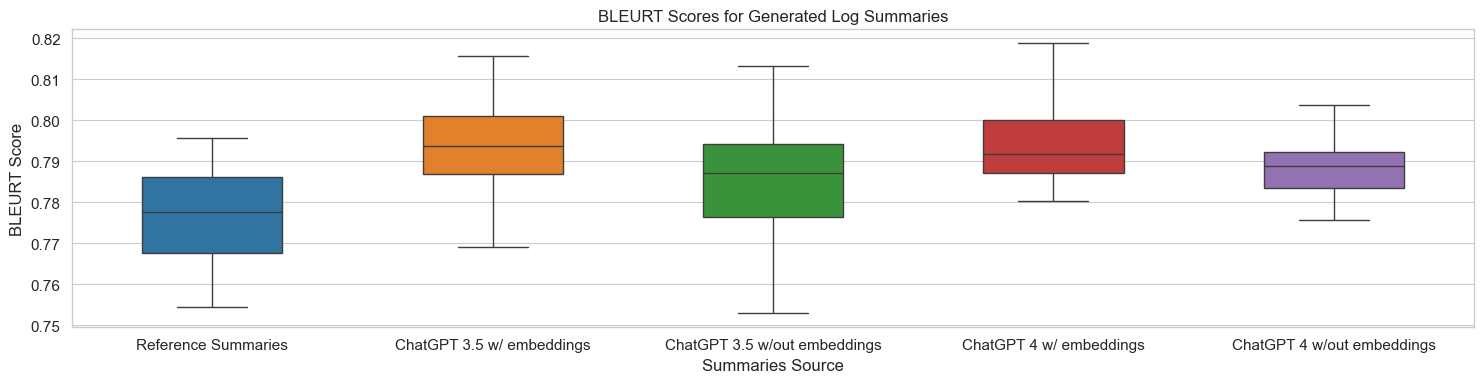

In [94]:
plt.figure(figsize=(15, 4))
sns.boxplot(y='BLEURT Score', x='Summaries Source', data=score_df, width=0.5, showfliers=False, hue='Summaries Source')
plt.title("BLEURT Scores for Generated Log Summaries")
plt.tight_layout()
plt.savefig("out/img/bleurt-scores.png", dpi=600)
plt.show()

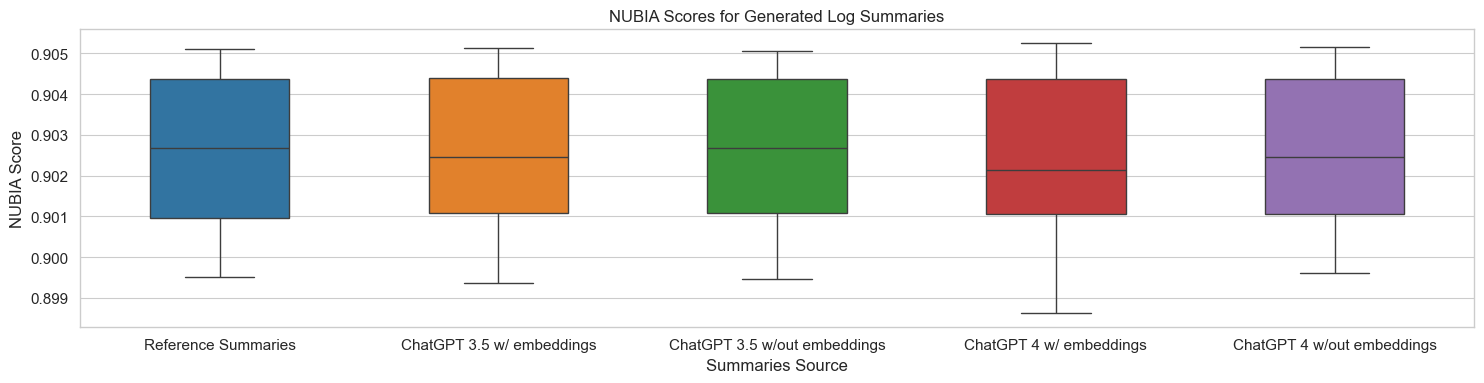

In [96]:
plt.figure(figsize=(15, 4))
sns.boxplot(y='NUBIA Score', x='Summaries Source', data=score_df, width=0.5, showfliers=False, hue='Summaries Source')
plt.title("NUBIA Scores for Generated Log Summaries")
plt.tight_layout()
plt.savefig("out/img/nubia-scores.png", dpi=600)
plt.show()